In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import random
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.manifold import TSNE
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import jaccard, cosine, euclidean, correlation, cityblock
from scipy.sparse import random

import keras
from keras import layers

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

pio.templates.default = "plotly"

pio.renderers.default = 'notebook_connected'
#pio.renderers.default = 'browser'

import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

# Problema de investigación: Clustering en extrema alta dimensionalidad
Como no se puede hacer clustering directo sobre un promedio de XXXX dimensiones para agrupar a los países por sector es necesario realizar previamente una reducción de la dimensionalidad.

Algunas de las herramientas existentes para la reducción de dimensionalidad:
* PCA
* t-SNE
* UMAP

Sus límites implican buscar alternativas que puedan enfrentar eficientemente el problema, tanto desde el punto de vista de la  exactitud de sus resultados (dificil de evaluar en una clasificación no supervisada) como desde el punto de vista computacional (que pueda ejecutarse y obtener resultados en un tiempo prudencial).

Una aproximación posible a este problema es la utilización de Autoencoders, redes neuronales cuyo propósito es la reducción de la dimensionalidad abstrayendo atributos de datos complejos a través de diferentes capas de procesamiento.

# Dataset Mnist
¿Por qué Mnist? Mnist es uno de los dataset más conocidos para aprender redes neuronales. Consiste en una gran variedad de fotos de números escritos a mano y puede utilizarse tanto para la clasificación (qué número es el que se escribió) como para utilizar encoders con los fines ya mencionados.

Otro motivo fundamental que inspira la idea reside en que en Mnist las fotos se ven como matrices esparsas (muy dispersas, poco densas, con gran cantidad de ceros) y eso la hace muy parecida al problema que estamos enfrentando a la hora de reducir la dimensionalidad de las exportaciones (atributos) de los distintos países (observaciones) de los diferentes sectores (clases).

Es decir la propuesta es tratar a cada tupla (país, producto) como una foto, como una forma de representar a las clases. sería como diferentes fotos de la clase "perro" o de la clase "número X".

*Una observación de la escritura del número 5 en una foto de 28$*$28 pixels:*
<img src="&quot;C:\Users\igalk\OneDrive\Documentos\laburo\CONICET\2023\productivity_comparison\ANN\numero_5.png&quot;"/>

In [2]:
nro_cinco = pd.read_csv("numero5.csv")
display(pd.DataFrame(nro_cinco).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '4px'}));

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0



*Una observación del sector 29 transformada en una foto de 73$*$73 pixels:*

In [3]:
raw_data = pd.read_csv(r"C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\BACI_HS17_Y2019_V202301.csv")
codigos = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\country_codes_V202301.csv')
GDP_L = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\GDP_L.csv')
region = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\region.csv')
ncm_ciiu = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\hs5_isic3.csv',
                                                    dtype={"HS5_6d":str,
                                                          "HS5_4d":str,
                                                          "HS5_2d":str,
                                                          "ISIC3_4d":str,
                                                          "ISIC3_3d":str,
                                                          "ISIC3_2d":str,
                                                          "ISIC3_1d":str})

In [4]:
raw_data.rename(columns={"k": "hs17_6d", "i": "x", "j": "m"}, inplace=True)
raw_data.drop(columns=["t", "m", "q"], inplace=True)
raw_data['hs17_6d'] = raw_data['hs17_6d'].astype(str)
raw_data['hs17_6d'] = raw_data['hs17_6d'].apply(lambda x: x.zfill(6) if len(x) == 5 else x)
raw_data = raw_data.groupby(['x','hs17_6d'], as_index=False)['v'].sum()

#raw_data["hs17_2d"] = raw_data['hs17_6d'].str[:2]

raw_data = raw_data.merge(codigos[["iso_3digit_alpha", 'country_code']], left_on='x', right_on='country_code',
                          how='left').drop(columns=['country_code', 'x']).rename(columns={"iso_3digit_alpha": "x"})

raw_data = pd.merge(raw_data, ncm_ciiu[['HS5_6d','ISIC3_2d']], left_on="hs17_6d", right_on="HS5_6d", how="left").drop(columns="HS5_6d").dropna()

#raw_data[["x", 'hs17_6d', "ISIC3_2d", "v"]].head(10)

In [122]:
raw_data["v_rel"] = raw_data['v'] / raw_data.groupby(['x', 'ISIC3_2d'])['v'].transform('sum')

#print(raw_data[(raw_data.x=='AFG') & (raw_data.ISIC3_2d=='29')]['v_rel'].sum())
#print(raw_data.head())
dataset= pd.pivot_table(raw_data, index="x", columns="hs17_6d", values="v_rel", fill_value= 0)


In [123]:
nuevas_colsA = pd.DataFrame(columns=["9998"+str(i) for i in range(10,100)])
nuevas_colsB = pd.DataFrame(columns=["9999"+str(i) for i in range(0,83)])

In [124]:
dataset = pd.concat([dataset, nuevas_colsA, nuevas_colsB], axis= 1).fillna(0)
sector = dataset.copy()

i='15'
columnas_a_ceros = ncm_ciiu.loc[ncm_ciiu.ISIC3_2d!=i,['HS5_6d', 'ISIC3_2d']]['HS5_6d'].to_list()
b = list((set(columnas_a_ceros) - set(sector.columns)))
columnas_a_ceros = [x for x in columnas_a_ceros if x not in b]
sector[columnas_a_ceros] = 0
sector = sector/max(sector.max())
image_sector = sector[sector.index=='ARG'].values.reshape((74, 74))
display(pd.DataFrame(image_sector).style.background_gradient(cmap ='RdYlGn').set_properties(**{'font-size': '4px'}));

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000017,0.033662,0.000888,0.003000,0.094440,0.000000,0.000000,0.000001,0.000212,0.000316,0.000587,0.000000,0.000001,0.000000,0.000000,0.000249,0.000018,0.000374,0.000052,0.000021,0.003138,0.000056,0.001160,0.001225,0.004963,0.000000,0.000005,0.000169,0.000004,0.000058,0.000016,0.004174,0.000003,0.011901,0.000000,0.000030,0.000000,0.000000,0.000000
1,0.000002,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000261,0.000000,0.000000,0.000000,0.000001,0.000013,0.000034,0.000000,0.000001,0.000001,0.000006,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000003,0.000000,0.000001,0.000003,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000005,0.000002,0.000000,0.000001,0.000010,0.000004,0.000000,0.000000,0.002578,0.000000,0.000011,0.000118,0.000009,0.000147,0.002320,0.000027,0.003887,0.000029,0.000014,0.000691,0.000003,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000075,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009
3,0.000000,0.000000,0.000000,0.008907,0.000000,0.001376,0.000022,0.000070,0.000455,0.000000,0.000093,0.000000,0.000000,0.000040,0.001080,0.000000,0.000048,0.000000,0.000000,0.001239,0.000000,0.000000,0.000053,0.000000,0.000023,0.000000,0.000000,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000354,0.000000,0.000000,0.000044,0.000002,0.000000,0.000071,0.000000,0.001182,0.000002,0.000441,0.044638,0.000001,0.000000,0.000000,0.000000,0.000000,0.000001,0.000002,0.000000,0.000000,0.000000,0.000012,0.000000,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.002200,0.000038,0.000000,0.000000
4,0.000004,0.000000,0.009121,0.000101,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000024,0.000006,0.000004,0.002328,0.012116,0.000041,0.000000,0.000028,0.000060,0.000042,0.003625,0.000175,0.002100,0.000000,0.001019,0.004468,0.000147,0.000029,0.000325,0.004973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000169,0.000003,0.000323,0.000063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000001,0.000001,0.000100,0.000005,0.000233,0.000000,0.000000,0.000000,0.000001,0.00

## Autoencoder más simple
### Mnist de la documentación de keras
[](https://blog.keras.io/building-autoencoders-in-keras.html)


In [8]:


# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [9]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)


In [10]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [11]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['mse'])


In [12]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [14]:

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.2769 - mse: 0.0695 - val_loss: 0.1869 - val_mse: 0.0401
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1693 - mse: 0.0342 - val_loss: 0.1526 - val_mse: 0.0288
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1442 - mse: 0.0260 - val_loss: 0.1341 - val_mse: 0.0228
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1293 - mse: 0.0212 - val_loss: 0.1221 - val_mse: 0.0189
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1187 - mse: 0.0178 - val_loss: 0.1131 - val_mse: 0.0161
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1111 - mse: 0.0154 - val_loss: 0.1069 - val_mse: 0.0142
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1059 - mse: 0.0137 - val_loss: 0.1026 - val_mse: 0.0128
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.

<AxesSubplot:>

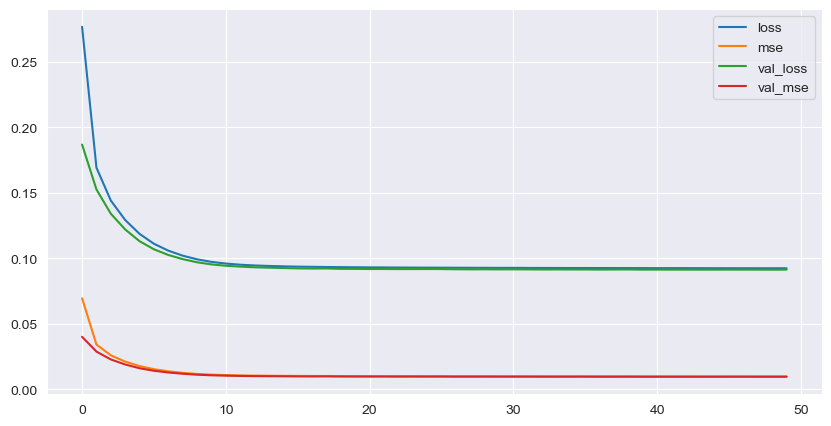

In [15]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

In [16]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


Mostrar la capacidad de reconstruccinon:

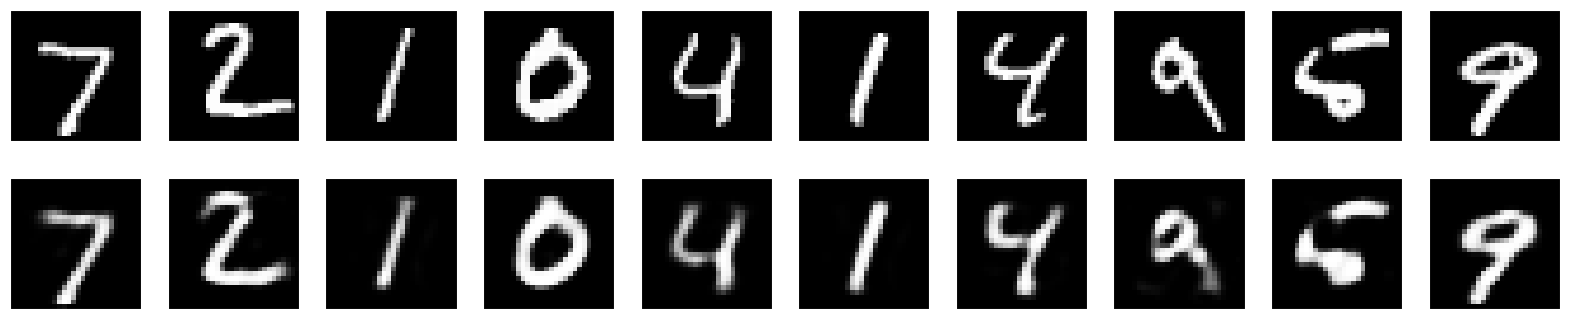

In [17]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## BACI
### Preparación dataset
/Necesito llegar a un dataset que sea un array de ($paises \cdot sectores$,74,74)
/Luego le hago el split train-test
3) como en este ejemplo ya era una fila no hace falta hacer el flatten. Necesito una array de (paises*sectores,73*73)
4) Hago la separacion train-test
5)

In [125]:
sectores_ciiu = list(ncm_ciiu.ISIC3_2d.dropna().drop_duplicates().sort_values())
nuevo_dataset = []
target=[]
for i in sectores_ciiu:
    print(i)
    sector = dataset.copy()
    columnas_a_ceros = ncm_ciiu.loc[ncm_ciiu.ISIC3_2d!=i,['HS5_6d', 'ISIC3_2d']]['HS5_6d'].to_list()
    b = list((set(columnas_a_ceros) - set(sector.columns)))
    columnas_a_ceros = [x for x in columnas_a_ceros if x not in b]
    sector[columnas_a_ceros] = 0
    sector = sector/max(sector.max())
    nuevo_dataset.append(sector)
    target.append([i]*sector.shape[0])
nuevo_dataset = pd.DataFrame(pd.concat(nuevo_dataset).reset_index(drop=True))
target = [element for nestedlist in target for element in nestedlist]

01
02
05
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
40
74
92
93


In [126]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(nuevo_dataset, test_size=0.2, random_state=42)


225

### ANN simple

In [24]:

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(5476,)) #5329 = 73*73
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(5476, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [25]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [26]:
#LR=0.0001
#default
#LR = 0.001
#optim= keras.optimizers.Adam(learning_rate=LR)

autoencoder.compile(optimizer='Adam',
                    loss='binary_crossentropy',
                    #metrics=['mse']
                    )



In [27]:

history = autoencoder.fit(train_df, train_df,
                epochs=15,
                batch_size=256, #256 funciona
                shuffle=True,
                validation_data=(test_df, test_df),
                )

Epoch 1/15
24/24 [==============================] - 2s 49ms/step - loss: 0.6865 - val_loss: 0.6770
Epoch 2/15
24/24 [==============================] - 1s 39ms/step - loss: 0.6575 - val_loss: 0.6280
Epoch 3/15
24/24 [==============================] - 1s 42ms/step - loss: 0.5828 - val_loss: 0.5269
Epoch 4/15
24/24 [==============================] - 1s 44ms/step - loss: 0.4627 - val_loss: 0.3942
Epoch 5/15
24/24 [==============================] - 1s 44ms/step - loss: 0.3299 - val_loss: 0.2695
Epoch 6/15
24/24 [==============================] - 1s 43ms/step - loss: 0.2201 - val_loss: 0.1780
Epoch 7/15
24/24 [==============================] - 1s 43ms/step - loss: 0.1456 - val_loss: 0.1199
Epoch 8/15
24/24 [==============================] - 1s 43ms/step - loss: 0.0995 - val_loss: 0.0845
Epoch 9/15
24/24 [==============================] - 1s 43ms/step - loss: 0.0714 - val_loss: 0.0624
Epoch 10/15
24/24 [==============================] - 1s 43ms/step - loss: 0.0537 - val_loss: 0.0480
Epoch 11/

<AxesSubplot:>

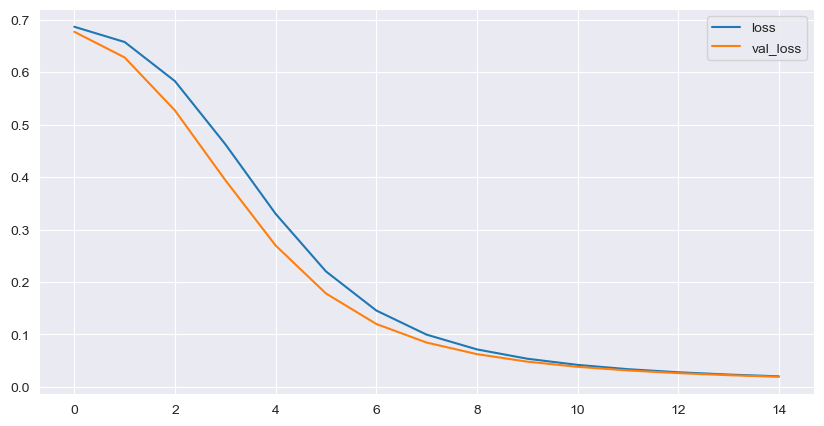

In [28]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

## Adding a sparsity constraint on the encoded representations
### Mnist

In [24]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [25]:
autoencoder.compile(optimizer='Adam',
                    loss='binary_crossentropy',
                    #metrics=['mse']
                    )

In [26]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.2878 - val_loss: 0.2013
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1802 - val_loss: 0.1617
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1534 - val_loss: 0.1436
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1387 - val_loss: 0.1316
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1288 - val_loss: 0.1235
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1219 - val_loss: 0.1178
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1171 - val_loss: 0.1138
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1136 - val_loss: 0.1109
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1111 - val_loss: 0.1088
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1092 - val_loss: 0.1072

<AxesSubplot:>

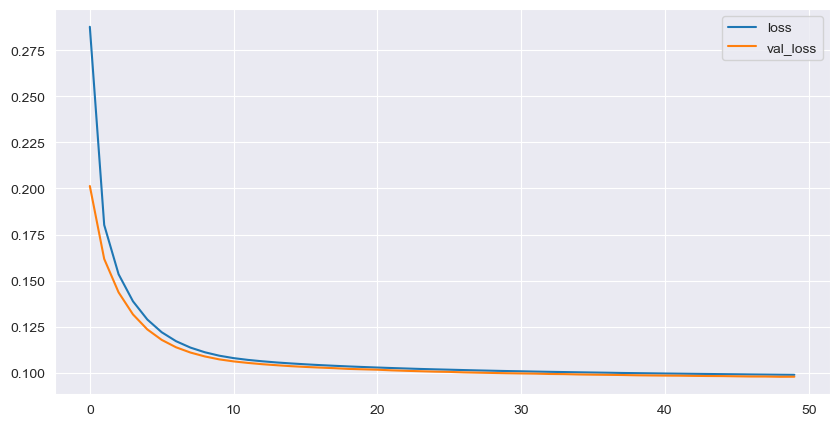

In [27]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

## BACI

In [28]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(5329,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(5329, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [29]:
autoencoder.compile(optimizer='Adam',
                    loss='binary_crossentropy',
                    #metrics=['mse']
                    )

In [30]:

history = autoencoder.fit(train_df, train_df,
                          epochs=50,
                          batch_size=256,  #256 funciona
                          shuffle=True,
                          validation_data=(test_df, test_df),
                          )

Epoch 1/50
24/24 [==============================] - 2s 50ms/step - loss: 0.6867 - val_loss: 0.6777
Epoch 2/50
24/24 [==============================] - 1s 39ms/step - loss: 0.6597 - val_loss: 0.6318
Epoch 3/50
24/24 [==============================] - 1s 39ms/step - loss: 0.5879 - val_loss: 0.5326
Epoch 4/50
24/24 [==============================] - 1s 39ms/step - loss: 0.4683 - val_loss: 0.3993
Epoch 5/50
24/24 [==============================] - 1s 40ms/step - loss: 0.3344 - val_loss: 0.2729
Epoch 6/50
24/24 [==============================] - 1s 40ms/step - loss: 0.2229 - val_loss: 0.1801
Epoch 7/50
24/24 [==============================] - 1s 40ms/step - loss: 0.1474 - val_loss: 0.1212
Epoch 8/50
24/24 [==============================] - 1s 39ms/step - loss: 0.1009 - val_loss: 0.0856
Epoch 9/50
24/24 [==============================] - 1s 39ms/step - loss: 0.0727 - val_loss: 0.0635
Epoch 10/50
24/24 [==============================] - 1s 41ms/step - loss: 0.0549 - val_loss: 0.0492
Epoch 11/

<AxesSubplot:>

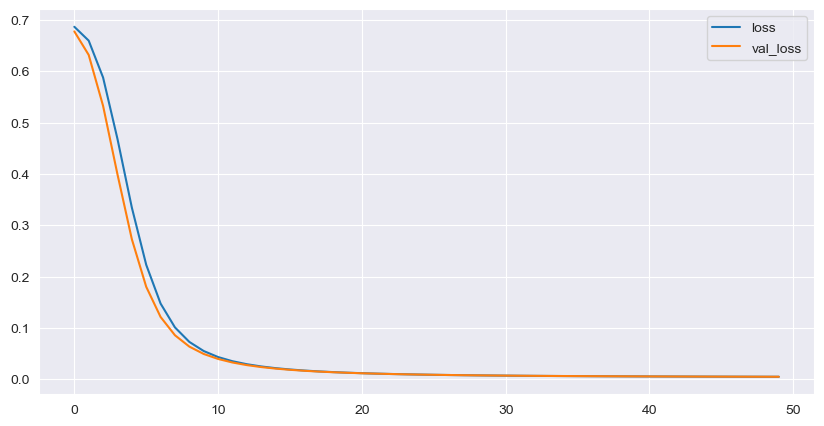

In [31]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

## Deep autoencoder
### Mnist

In [32]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [34]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 3s 7ms/step - loss: 0.0960 - val_loss: 0.0934
Epoch 2/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0942 - val_loss: 0.0933
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0936 - val_loss: 0.0923
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0930 - val_loss: 0.0919
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 0.0912
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0919 - val_loss: 0.0910
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0915 - val_loss: 0.0904
Epoch 8/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0910 - val_loss: 0.0899
Epoch 9/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0905 - val_loss: 0.0893
Epoch 10/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0900 - val_lo

<AxesSubplot:>

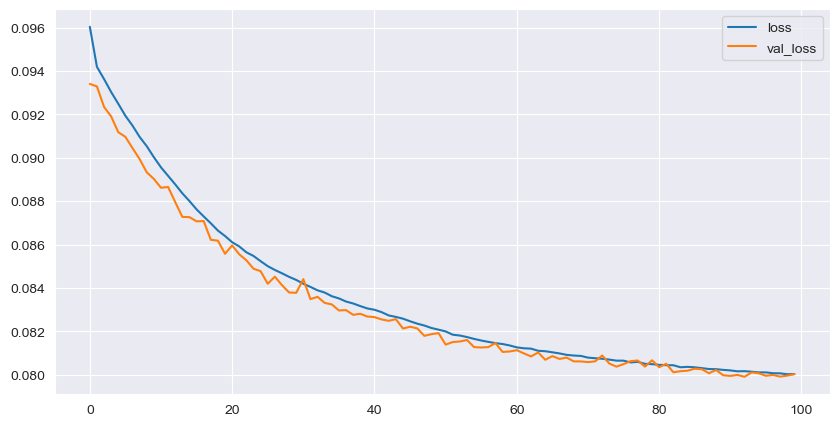

In [36]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

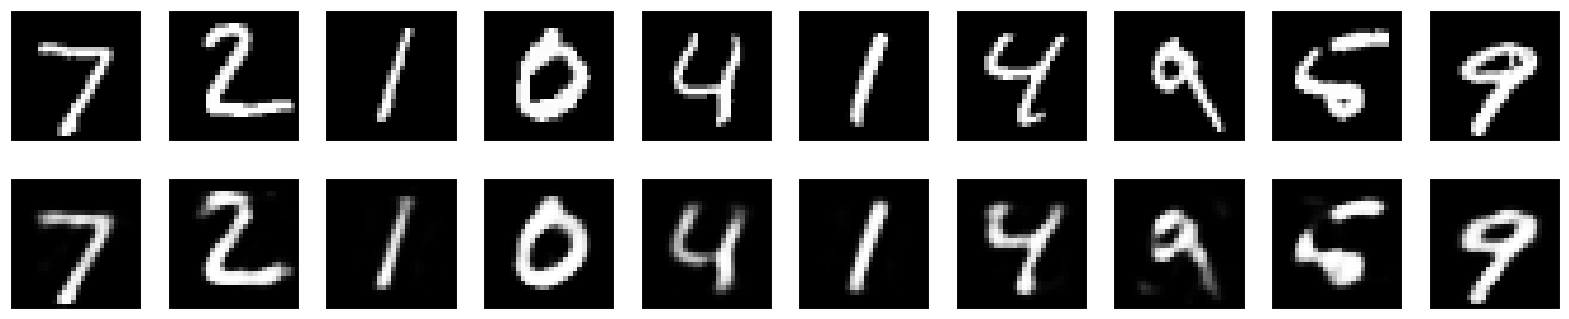

In [37]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### BACI

In [42]:
input_img = keras.Input(shape=(5476,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

flatten = layers.Flatten()(encoded)

# Reduce the dimensions to 32-D
latent = layers.Dense(2)(flatten)

# Reshape back to the original shape
reshape = layers.Reshape((1, 1, 2))(latent)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(5476, activation='sigmoid')(decoded)


In [43]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [44]:
history = autoencoder.fit(train_df, train_df,
                          epochs=50,
                          batch_size=256,  #256 funciona
                          shuffle=True,
                          validation_data=(test_df, test_df),
                          )

Epoch 1/50
24/24 [==============================] - 3s 67ms/step - loss: 0.6770 - val_loss: 0.6184
Epoch 2/50
24/24 [==============================] - 1s 61ms/step - loss: 0.2937 - val_loss: 0.0049
Epoch 3/50
24/24 [==============================] - 1s 58ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/50
24/24 [==============================] - 1s 54ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/50
24/24 [==============================] - 1s 54ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
24/24 [==============================] - 1s 57ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/50
24/24 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
24/24 [==============================] - 1s 59ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
24/24 [==============================] - 1s 60ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
24/24 [==============================] - 1s 61ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/

<AxesSubplot:>

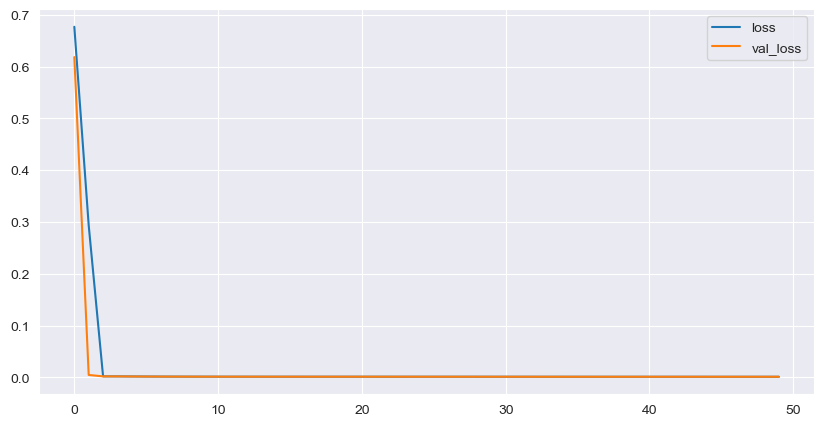

In [45]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

## Convolutional autoencoder
### MNIST

In [48]:
x_train_sqr = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_sqr = np.reshape(x_test, (len(x_test), 28, 28, 1))

NameError: name 'x_train' is not defined

In [135]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
flatten = layers.Flatten()(encoded)

# Reduce the dimensions to 128-D
latent = layers.Dense(2)(flatten)

# Reshape back to the original shape
reshape = layers.Reshape((1, 1, 2))(latent)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [113]:
history = autoencoder.fit(x_train_sqr, x_train_sqr,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_sqr, x_test_sqr))

Epoch 1/100
 94/235 [===========>..................] - ETA: 13s - loss: 0.3711

KeyboardInterrupt: 

<AxesSubplot:>

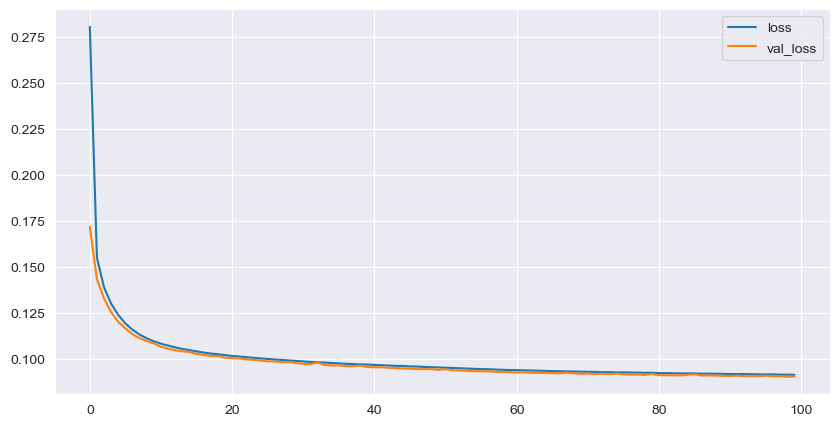

In [53]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

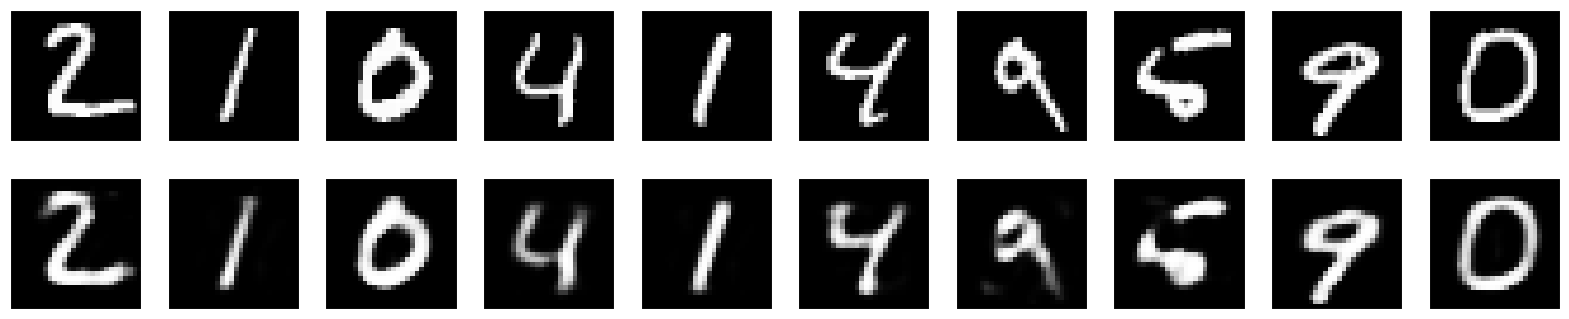

In [54]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### BACI

In [127]:
train_df_sqr = np.reshape(train_df.to_numpy(), (len(train_df.to_numpy()), 74, 74, 1))
test_df_sqr = np.reshape(test_df.to_numpy(), (len(test_df.to_numpy()), 74, 74, 1))

In [189]:
import keras
from keras import layers

input_img = keras.Input(shape=(74, 74, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point, the representation is (10, 10, 8) i.e., 800-dimensional
flatten = layers.Flatten()(encoded)

# Reduce the dimensions to 800-D
latent = layers.Dense(2)(flatten)

# Reshape back to the original shape
reshape = layers.Reshape((1, 1, 2))(latent)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Crop the decoded output to match the original input size
crop_size = (decoded.shape[1] - input_img.shape[1]) // 2
cropped = layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(decoded)

autoencoder = keras.Model(input_img, cropped)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()



Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_91 (InputLayer)       [(None, 74, 74, 1)]       0         
                                                                 
 conv2d_646 (Conv2D)         (None, 74, 74, 16)        160       
                                                                 
 max_pooling2d_280 (MaxPooli  (None, 37, 37, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_647 (Conv2D)         (None, 37, 37, 8)         1160      
                                                                 
 max_pooling2d_281 (MaxPooli  (None, 19, 19, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_648 (Conv2D)         (None, 19, 19, 8)         584

In [190]:
history = autoencoder.fit(train_df_sqr, train_df_sqr,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(test_df_sqr, test_df_sqr))

Epoch 1/10
24/24 [==============================] - 19s 692ms/step - loss: 0.5421 - val_loss: 0.1367
Epoch 2/10
24/24 [==============================] - 14s 600ms/step - loss: 0.0172 - val_loss: 0.0025
Epoch 3/10
24/24 [==============================] - 15s 614ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/10
24/24 [==============================] - 16s 670ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
24/24 [==============================] - 16s 666ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/10
24/24 [==============================] - 16s 666ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/10
24/24 [==============================] - 16s 653ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 15s 640ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 16s 659ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0025 - val_lo

<AxesSubplot:>

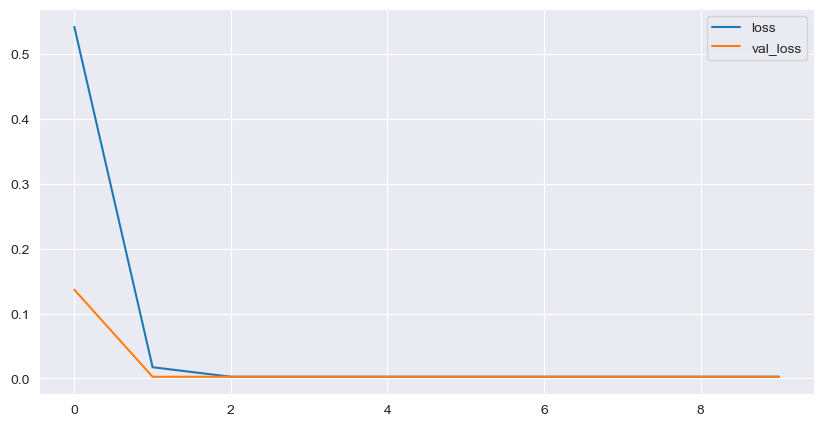

In [191]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

### Deeper Convolutional autoencoder --> 2D

In [185]:
import keras
from keras import layers
from keras import regularizers

input_img = keras.Input(shape=(74, 74, 1))

# Encoder
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5

# Flatten the encoded representation
flatten = layers.Flatten()(encoded)

# Reduce the dimensions to 2-D
latent = layers.Dense(2)(flatten)

# Reshape back to the original shape
reshape = layers.Reshape((1, 1, 2))(latent)

# Decoder
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(reshape)
x = layers.UpSampling2D((4, 4))(x)
x = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Dropout(0.5)(x)  # Dropout regularization with rate 0.5

x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.UpSampling2D((3, 3))(x)

crop_size = int((decoded.shape[1] - input_img.shape[1]) // 2)
cropped = layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(decoded)

autoencoder = keras.Model(input_img, cropped)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()





Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 74, 74, 1)]       0         
                                                                 
 conv2d_625 (Conv2D)         (None, 74, 74, 4)         40        
                                                                 
 max_pooling2d_271 (MaxPooli  (None, 37, 37, 4)        0         
 ng2D)                                                           
                                                                 
 dropout_152 (Dropout)       (None, 37, 37, 4)         0         
                                                                 
 conv2d_626 (Conv2D)         (None, 37, 37, 4)         148       
                                                                 
 max_pooling2d_272 (MaxPooli  (None, 19, 19, 4)        0         
 ng2D)                                                    

In [186]:
history = autoencoder.fit(train_df_sqr, train_df_sqr,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(test_df_sqr, test_df_sqr))

Epoch 1/50
24/24 [==============================] - 7s 216ms/step - loss: 0.8709 - val_loss: 0.8351
Epoch 2/50
24/24 [==============================] - 5s 202ms/step - loss: 0.8004 - val_loss: 0.7604
Epoch 3/50
12/24 [==============>...............] - ETA: 2s - loss: 0.7419

KeyboardInterrupt: 

In [ ]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

In [167]:
encoder = keras.Model(inputs=autoencoder.input, outputs=latent)
encoded_data = encoder.predict(nuevo_dataset.values.reshape(-1, 74, 74, 1))
encoded_data_2d = encoded_data.reshape(encoded_data.shape[0], -1)


240/240 [==============================] - 2s 8ms/step


In [168]:
display(pd.DataFrame(encoded_data_2d))

,0,1
0,5.133785,-4.186327
1,5.139424,-4.191373
2,5.140648,-4.192748
3,5.139500,-4.190385
4,5.142540,-4.194181
...,...,...
7645,5.129460,-4.182548
7646,5.129460,-4.182548
7647,5.146002,-4.200946
7648,5.129460,-4.182548


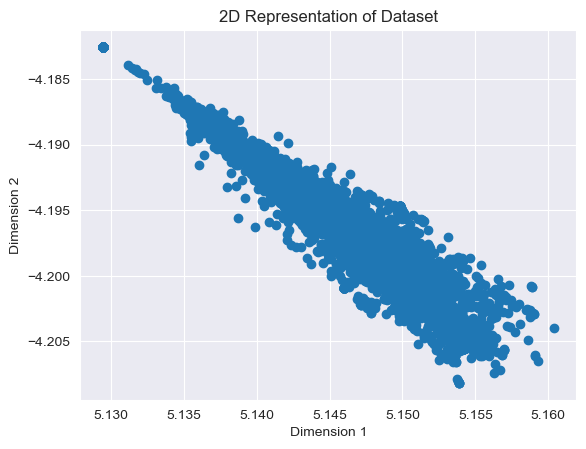

In [169]:

x = encoded_data_2d[:, 0]
y = encoded_data_2d[:, 1]
plt.scatter(x, y)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Representation of Dataset')
plt.show()

## Variational autoencoder (VAE)
### Mnist

In [196]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Define the VAE as a `Model` with a custom `train_step`
"""

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(mnist_digits, epochs=3, batch_size=128)

vae.fit(x_train,
                epochs=3,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test))

"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt





Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_655 (Conv2D)            (None, 14, 14, 32)   320         ['input_94[0][0]']               
                                                                                                  
 conv2d_656 (Conv2D)            (None, 7, 7, 64)     18496       ['conv2d_655[0][0]']             
                                                                                                  
 flatten_68 (Flatten)           (None, 3136)         0           ['conv2d_656[0][0]']             
                                                                                            

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

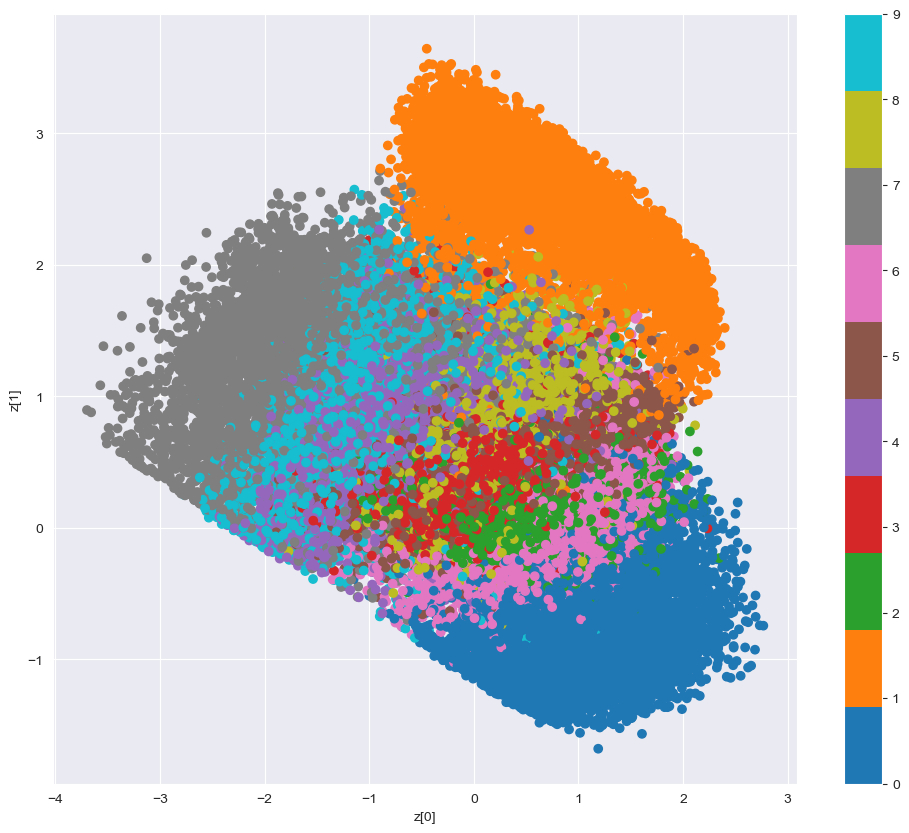

In [192]:
"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [193]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()

In [194]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

VAE, otro intento
fuente: https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/


### Encoder

In [24]:
import tensorflow
import numpy

In [37]:
# Encoder
img_size = 74
num_channels = 1
latent_space_dim = 2

x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()


Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 74, 74, 1)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 74, 74, 1)    10          ['encoder_input[0][0]']          
                                                                                                  
 encoder_norm_1 (BatchNormaliza  (None, 74, 74, 1)   4           ['encoder_conv_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 encoder_leakyrelu_1 (LeakyReLU  (None, 74, 74, 1)   0           ['encoder_norm_1[0][0

### Decoder


In [41]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

crop_size = int((decoder_output.shape[1] - input_img.shape[1]) // 2)
cropped = layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(decoder_output)

decoder = tensorflow.keras.models.Model(decoder_input, cropped, name="decoder_model")




decoder.summary()


ValueError: The `1st entry of cropping` argument must be a tuple of 2 integers. Received: (-354, -354) including {-354} that does not satisfy the requirement `>= 0`.

### VAE

In [27]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [29]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

### Training

In [31]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [32]:
x_train = numpy.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = numpy.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [34]:
history = vae.fit(x_train, x_train,
        epochs=5,
        batch_size=32,
        shuffle=True,
        validation_data=(x_test, x_test))

Epoch 1/5
1875/1875 [==============================] - 134s 72ms/step - loss: 54.5254 - val_loss: 52.9065
Epoch 2/5
1875/1875 [==============================] - 133s 71ms/step - loss: 49.7251 - val_loss: 48.6899
Epoch 3/5
1875/1875 [==============================] - 134s 72ms/step - loss: 47.9344 - val_loss: 47.4982
Epoch 4/5
1875/1875 [==============================] - 137s 73ms/step - loss: 46.7927 - val_loss: 46.8281
Epoch 5/5
1875/1875 [==============================] - 138s 74ms/step - loss: 45.8414 - val_loss: 45.5408


<AxesSubplot:>

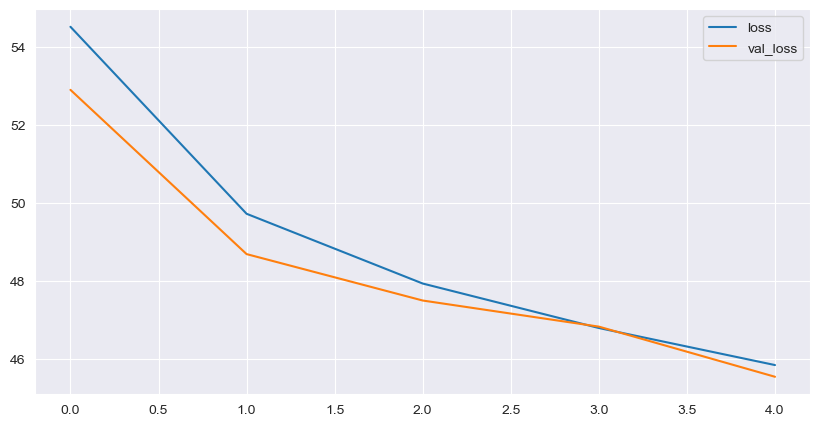

In [35]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

oootra versión

https://github.com/wikibook/keras/blob/master/chapter3-autoencoders/autoencoder-2dim-mnist-3.2.2.py


In [59]:
'''Example of autoencoder model on MNIST dataset using 2dim latent

The autoencoder forces the encoder to discover 2-dim latent vector
that the decoder can recover the original input. The 2-dim latent
vector is projected on 2D space to analyze the distribution of codes
in the latent space. The latent space can be navigated by varying the
values of latent vector to produce new MNIST digits.

This autoencoder has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os


def plot_results(models,
                 data,
                 batch_size, #32
                 model_name="autoencoder_2dim"):
    """Plots 2-dim latent values as color gradient
        then, plot MNIST digits as function of 2-dim latent vector

    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(x_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()



# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
optim= keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(loss='binary_crossentropy', optimizer=optim)

# train the autoencoder
history =  autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=30,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_14 (Flatten)        (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________________

KeyboardInterrupt: 

In [ ]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

In [ ]:

# # predict the autoencoder output from test data
# x_decoded = autoencoder.predict(x_test)
#
# # display the 1st 8 test input and decoded images
# imgs = np.concatenate([x_test[:8], x_decoded[:8]])
# imgs = imgs.reshape((4, 4, image_size, image_size))
# imgs = np.vstack([np.hstack(i) for i in imgs])
# plt.figure()
# plt.axis('off')
# plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
# plt.imshow(imgs, interpolation='none', cmap='gray')
# plt.savefig('input_and_decoded.png')
# plt.show()

# project the 2-dim latent on 2D space
models = (encoder, decoder)
data = (x_test, y_test)
plot_results(models, data,
             batch_size=batch_size,
             model_name="autonencoder-2dim")

#BACI red convolucional


In [156]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Cropping2D

image_size = train_df_sqr.shape[1]
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same',
               kernel_regularizer=regularizers.l2(0.01))(x)

    x = Dropout(0.2)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 74, 74, 1)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 37, 37, 128)       1280      
                                                                 
 dropout_12 (Dropout)        (None, 37, 37, 128)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 19, 19, 256)       295168    
                                                                 
 dropout_13 (Dropout)        (None, 19, 19, 256)       0         
                                                                 
 flatten_23 (Flatten)        (None, 92416)             0         
                                                                 
 latent_vector (Dense)       (None, 2)                 1848

In [157]:



# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same',
                        kernel_regularizer=regularizers.l2(0.01))(x)

    x = Dropout(0.2)(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output',
                           kernel_regularizer=regularizers.l2(0.01))(x)

crop_size = int((outputs.shape[1] - 74) // 2)
cropped = Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(outputs)

# instantiate decoder model
decoder = Model(latent_inputs, cropped, name='decoder')

#decoder = Model(latent_inputs, outputs, name='decoder')


decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_23 (Dense)            (None, 92416)             277248    
                                                                 
 reshape_25 (Reshape)        (None, 19, 19, 256)       0         
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 38, 38, 256)      590080    
 Transpose)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 38, 38, 256)       0         
                                                                 
 conv2d_transpose_43 (Conv2D  (None, 76, 76, 128)      295040    
 Transpose)                                                

In [158]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


# Mean Square Error (MSE) loss function, Adam optimizer
#optim= keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(loss='binary_crossentropy', optimizer='Adam')

# train the autoencoder
history =  autoencoder.fit(train_df_sqr, train_df_sqr,
                validation_data=(test_df_sqr, test_df_sqr),
                epochs=50,
                batch_size=batch_size)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 74, 74, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 481282    
                                                                 
 decoder (Functional)        (None, 74, 74, 1)         1163521   
                                                                 
Total params: 1,644,803
Trainable params: 1,644,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
192/192 [==============================] - 202s 1s/step - loss: 0.4352 - val_loss: 0.0072
Epoch 2/50
192/192 [==============================] - 159s 830ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/50
192/192 [==============================] - 157s 818ms/step - loss: 0.0030 - val_loss: 0.0027


KeyboardInterrupt: 

<AxesSubplot:>

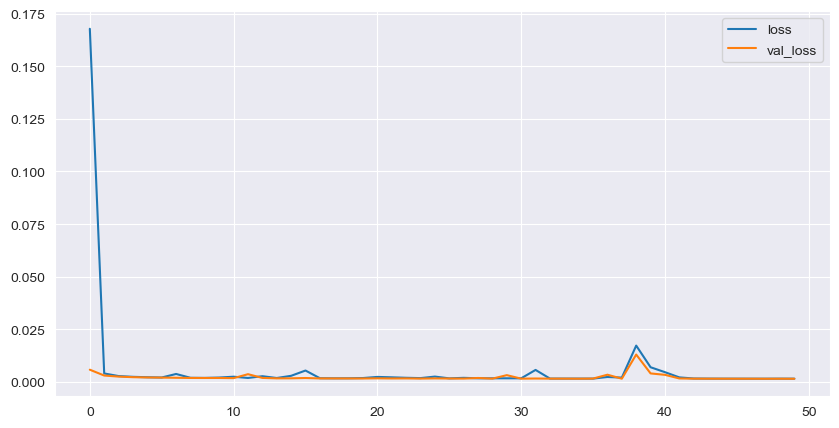

In [159]:
history_mlp_plot = history.history

# La pasamos a un dataframe
loss_acc_df = pd.DataFrame(history_mlp_plot)

loss_acc_df.plot(figsize=(10,5))

In [128]:

# display a 2D plot of the digit classes in the latent space
nuevo_dataset_sqr = np.reshape(nuevo_dataset.to_numpy(), (len(nuevo_dataset.to_numpy()), 74, 74, 1))


In [134]:

z = pd.DataFrame(encoder.predict(nuevo_dataset_sqr, batch_size=batch_size))
z['target'] = target

240/240 [==============================] - 2s 6ms/step


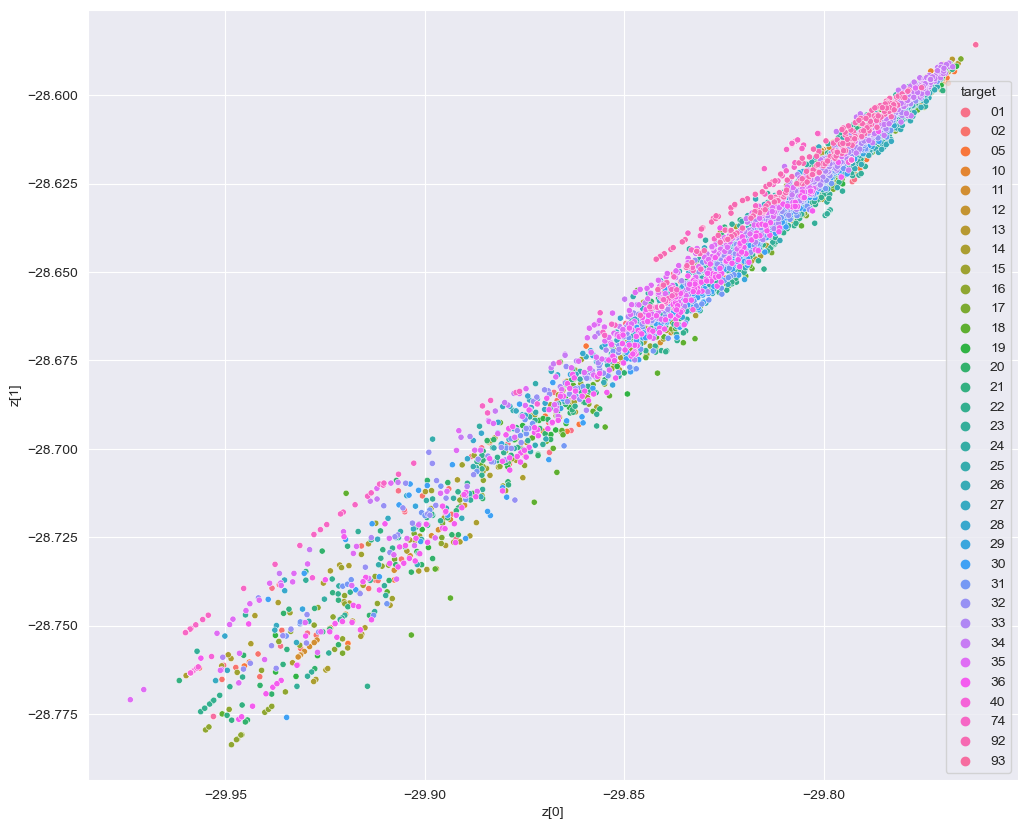

In [144]:

plt.figure(figsize=(12, 10))

# n_colors = np.linspace(0, 1, len(sectores_ciiu))
# cmap = plt.cm.colors.ListedColormap(n_colors)
sns.color_palette("rocket")
sns.scatterplot(data=z, x=z[0], y= z[1], hue="target", s = 20)


plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()